## Phase frequency trend 

In [2]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/validation


In [3]:
import numpy as np
import scipy as sc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy import signal

In [4]:
def theta1_cal( pc1, pc2 ):
    theta1           =  np.zeros(pc2.size)
    angle180         =  np.arctan2(-pc2, -pc1) * 180 / np.pi
    indNeg           =  np.where(angle180<0)[0]
    angle360         = angle180
    angle360[indNeg] = angle180[indNeg] + 360
    theta1           = np.around( ( angle360 + 22.5 ) * 8 / 360 )
    return theta1

def seas_separate(theta1_rmm,amp1_rmm,s_year,e_year):
    ph1=theta1_rmm.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']*1
    a1=amp1_rmm.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']*1
    return ph1,a1


def phase_freq_cal(theta1_rmm,amp1_rmm,threshold,s_year,n):
    t123 = np.zeros((n,))
    t567 = np.zeros((n,))
    t78 =np.zeros((n,))
    n1   = s_year
    
    for i in np.arange(n):
        a=[];p=[];
        p,a  = seas_separate(theta1_rmm,amp1_rmm,n1,n1+1)
        k    = np.where(a<threshold)[0]
        p[k] = 0  
        t123[i] = np.size(np.where(p==1)[0])+np.size(np.where(p==2)[0])+np.size(np.where(p==3)[0])
        t567[i] = np.size(np.where(p==4)[0])+np.size(np.where(p==5)[0])+np.size(np.where(p==6)[0])
        t78[i] = np.size(np.where(p==7)[0])+np.size(np.where(p==8)[0])

        n1 = n1+1
        
    return t123,t567,t78

def tot_phase(theta1_rmm,amp1_rmm,threshold,s_year,n):
    tt = np.zeros((n,))
    n1   = s_year
    for i in np.arange(n):
        a=[];p=[];
        p,a  = seas_separate(theta1_rmm,amp1_rmm,n1,n1+1)
        k    = np.where(a<threshold)[0]
        p[k] = 0  
        tt[i] = len(np.where(p!=0)[0])
        n1= n1+1
    return tt


def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal

def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal


def smooth(x,window_len=11,window='hanning'):
    ##https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
        
    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [5]:
st = 1979 ; en = 2015 #; threshold = 1.0 ;
n = en-st;    
lf = 10;wn = 3
factor = 1.5

## WH04 RMM index

In [6]:
rmm = xr.open_dataset('RMM_WH04_index_new.nc')
rmm1 = rmm['PC1'].loc[str(st)+'-01-01':str(en)+'-12-31']
rmm2 = rmm['PC2'].loc[str(st)+'-01-01':str(en)+'-12-31']

amp1_wh04 = rmm['MJO_INDEX']
phase1_wh04 = theta1_cal( rmm1, rmm2 )



In [7]:
# rm11 = np.real(lowpass_scipy(rmm1.values,sample_freq=1,time_period=10,keep_mean=1))
rm11 = lowpass_scipy_butter(rmm1.values,wn,lf)
rmm11 = pd.Series(rm11,index  = rmm1.time.values)

# rm22 = np.real(lowpass_scipy(rmm2.values,sample_freq=1,time_period=10,keep_mean=1))
rm22 = lowpass_scipy_butter(rmm2.values,wn,lf)
rmm22 = pd.Series(rm22,index  = rmm2.time.values)


amp1_wh04_filt = (rmm11**2+rmm22**2)**0.5
phase1_wh04_filt = theta1_cal( rmm11, rmm22 )

print(np.mean(amp1_wh04_filt),np.std(amp1_wh04_filt)*factor,amp1_wh04_filt.loc['1979-01-01':'2008-12-31'].std()*factor)

1.2446764180078507 0.9705816148009123 0.9707128313860527


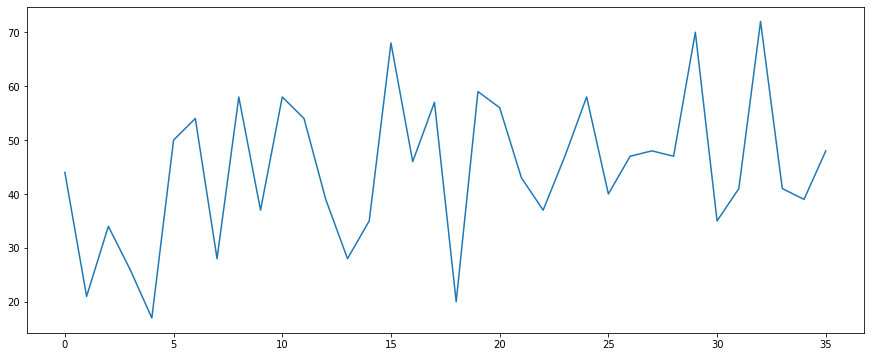

In [8]:
threshold = np.std(amp1_wh04_filt.loc['1979-01-01':'2008-12-31'])*factor
tt_wh04 = tot_phase(phase1_wh04_filt,amp1_wh04_filt,threshold,st,n)
t123_wh04,t567_wh04,t78_wh04 = phase_freq_cal(phase1_wh04_filt,amp1_wh04_filt,threshold,st,n)
plt.figure(figsize=(15,6))
plt.plot(t567_wh04)

In [9]:
# threshold = 1#np.std(amp1_wh04.loc['1979-01-01':'2008-12-31'])*factor
# tt_wh04 = tot_phase(phase1_wh04,amp1_wh04,threshold,st,n)
# t123_wh04,t567_wh04,t78_wh04 = phase_freq_cal(phase1_wh04,amp1_wh04,threshold,st,n)
# plt.figure(figsize=(15,6))
# plt.plot(t567_wh04)
# phase1_wh04.loc['1979-11-01':'1980-04-30'],t567_wh04

## Oliver Index

In [10]:
df2 = pd.read_csv('rmm_oliver_20CRv3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)



d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_ol = (d1_ol**2+d2_ol**2)**0.5


phase1_ol = theta1_cal( d1_ol, d2_ol )
amp1_ol = mjo_ind_ol.loc[str(st)+'-01-01':str(en)+'-12-31']

print(np.mean(amp1_ol),np.std(amp1_ol)*factor, np.std(amp1_ol.loc['1979-01-01':'2008-12-31'])*factor)

1.3380436663400652 1.1204643988286362 1.1237478215954968


15.022719419779897 10.44163673845139 13.373435064787909 10.646537720409333


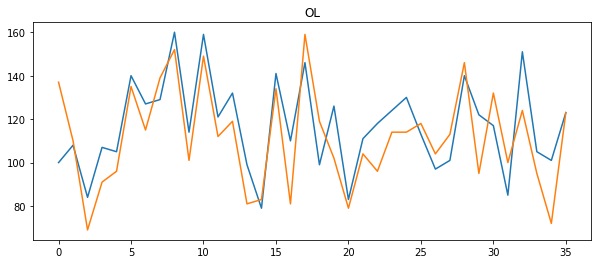

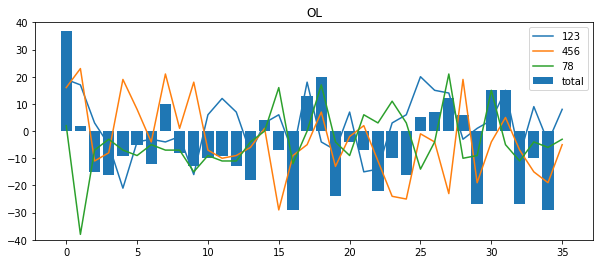

In [11]:
threshold = np.std(amp1_ol.loc['1979-01-01':'2008-12-31'])*factor
tt_ol = tot_phase(phase1_ol,amp1_ol,threshold,st,n)
t123_ol, t567_ol,t78_ol = phase_freq_cal(phase1_ol,amp1_ol,threshold,st,n)
plt.figure(figsize=(10,4))
plt.plot(tt_wh04)
plt.plot(tt_ol)
plt.title('OL')

plt.figure(figsize=(10,4))
plt.plot(t123_ol-t123_wh04,label='123')
plt.plot(t567_ol-t567_wh04,label='456')
plt.plot(t78_ol-t78_wh04,label='78')
plt.bar(np.arange(36),tt_ol-tt_wh04,label='total')
plt.ylim([-40,40])
plt.legend()
plt.title('OL')

print(np.std(tt_ol-tt_wh04),np.std(t123_ol-t123_wh04),np.std(t567_ol-t567_wh04),np.std(t78_ol-t78_wh04))


No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

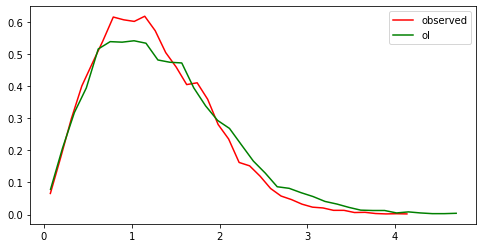

In [12]:
plt.figure(figsize=(16,8))
n1,x1,_=plt.hist(amp1_wh04_filt,bins=35,density=True,alpha=0.5,histtype='step',label='observed')


n2,x2,_=plt.hist(amp1_ol,bins=35,density=True,alpha=0.5,histtype='step',label='ol')

plt.clf()
plt.figure(figsize=(8,4))

plt.legend()
bin_centers1 = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers1,n1,'r',label='observed')
bin_centers2 = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers2,n2,'g',label='ol')
# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')
plt.legend()

## CONV index 

In [13]:
#df11 = pd.read_csv('rmm1_1905_2015_svr_predict.txt')
# df11 = pd.read_csv('rmm1_conv_1905_2015.csv')
# df11 = pd.read_csv('rmm1_MLR_org.txt')
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble/rmm1_1905_2015_(109,)p1.txt')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_conv = df11.drop('Datetime',axis=1)
df11_conv = df11_conv[['rmm1']]/df11_conv['rmm1'].loc['1979-01-01':'2008-12-31'].std()

#df22 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
# df22 = pd.read_csv('rmm2_conv_1905_2015.csv')
# df22 = pd.read_csv('rmm2_MLR_org.txt')

df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble/rmm2_1905_2015_(186,).txt')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_conv = df22.drop('Datetime',axis=1)
df22_conv = df22_conv[['rmm2']]/df22_conv['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_conv = df11_conv['rmm1'][(df11_conv.index >= datetime.datetime(st,1,1)) & (df11_conv.index  <= datetime.datetime(en,12,31))]
d2_conv = df22_conv['rmm2'][(df22_conv.index >= datetime.datetime(st,1,1)) & (df22_conv.index  <= datetime.datetime(en,12,31))]

mjo_ind_conv = (d1_conv**2+d2_conv**2)**0.5

phase1_conv = theta1_cal( d1_conv, d2_conv )
amp1_conv = mjo_ind_conv.loc[str(st)+'-01-01':str(en)+'-12-31']

print(np.mean(amp1_conv),np.std(amp1_conv)*factor,np.std(amp1_conv.loc['1979-01-01':'2008-12-31'])*factor)

1.2421362154243432 0.9719126651294752 0.973546489373998


(11.875771579871513, 8.925056627409662, 9.18781231097634, 7.743974160756809)

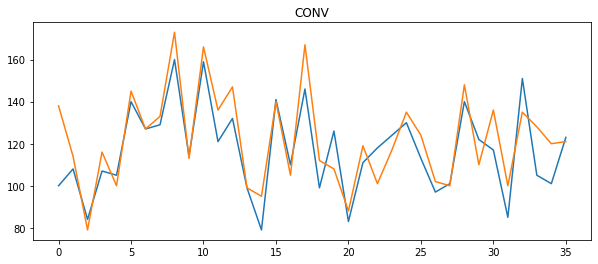

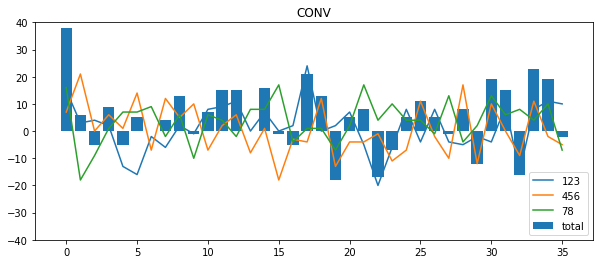

In [14]:
threshold = np.std(amp1_conv.loc['1979-01-01':'2008-12-31'])*factor
tt_conv = tot_phase(phase1_conv,amp1_conv,threshold,st,n)
t123_conv, t567_conv,t78_conv = phase_freq_cal(phase1_conv,amp1_conv,threshold,st,n)
plt.figure(figsize=(10,4))
plt.plot(tt_wh04)
plt.plot(tt_conv)
plt.title('CONV')

plt.figure(figsize=(10,4))
plt.plot(t123_conv-t123_wh04,label='123')
plt.plot(t567_conv-t567_wh04,label='456')
plt.plot(t78_conv-t78_wh04,label='78')
plt.bar(np.arange(36),tt_conv-tt_wh04,label='total')
plt.ylim([-40,40])
plt.title('CONV')
plt.legend()
np.std(tt_conv-tt_wh04),np.std(t123_conv-t123_wh04),np.std(t567_conv-t567_wh04),np.std(t78_conv-t78_wh04)

No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

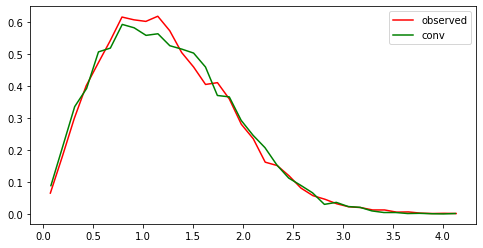

In [15]:
plt.figure(figsize=(16,8))
n1,x1,_=plt.hist(amp1_wh04_filt,bins=35,density=True,alpha=0.5,histtype='step',label='observed')

n2,x2,_=plt.hist(amp1_conv,bins=35,density=True,alpha=0.5,histtype='step',label='conv')

plt.clf()
plt.figure(figsize=(8,4))

plt.legend()
bin_centers1 = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers1,n1,'r',label='observed')
bin_centers2 = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers2,n2,'g',label='conv')
# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')
plt.legend()

## MLR :

In [16]:

df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11 = df11.drop('Datetime',axis=1)
df11 = df11[['rmm1']]/df11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22 = df22.drop('Datetime',axis=1)
df22 = df22[['rmm2']]/df22['rmm2'].loc['1979-01-01':'2008-12-31'].std()

# df11.columns =['rmm1']
# df22.columns =['rmm2']



d1_mlr = df11['rmm1'][(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_mlr = df22['rmm2'][(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]

mjo_ind_mlr = (d1_mlr**2+d2_mlr**2)**0.5

phase1_mlr = theta1_cal( d1_mlr, d2_mlr )
amp1_mlr = mjo_ind_mlr.loc[str(st)+'-01-01':str(en)+'-12-31']
print(np.mean(amp1_mlr),np.std(amp1_mlr)*factor,np.std(amp1_mlr.loc['1979-01-01':'2008-12-31'])*factor)

1.2300048408195803 1.0252670470991754 1.0223506213104732


(13.742562522737819, 10.333333333333332, 11.275451319975435, 9.795123503276743)

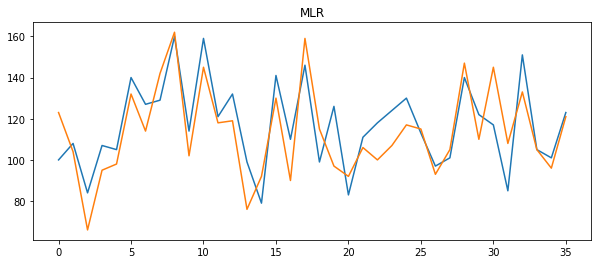

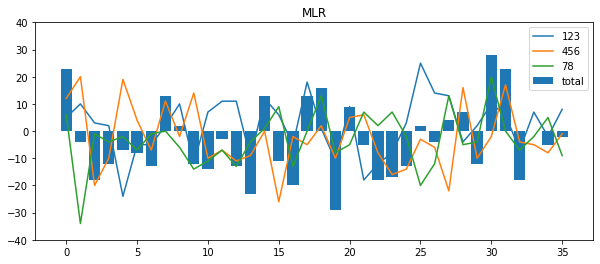

In [17]:
threshold = np.std(amp1_mlr.loc['1979-01-01':'2008-12-31'])*factor
tt_mlr = tot_phase(phase1_mlr,amp1_mlr,threshold,st,n)
t123_mlr, t567_mlr,t78_mlr = phase_freq_cal(phase1_mlr,amp1_mlr,threshold,st,n)
plt.figure(figsize=(10,4))
plt.plot(tt_wh04)
plt.plot(tt_mlr)
plt.title('MLR')

plt.figure(figsize=(10,4))
plt.plot(t123_mlr-t123_wh04,label='123')
plt.plot(t567_mlr-t567_wh04,label='456')
plt.plot(t78_mlr-t78_wh04,label='78')
plt.bar(np.arange(36),tt_mlr-tt_wh04,label='total')
plt.ylim([-40,40])
plt.title('MLR')
plt.legend()
np.std(tt_mlr-tt_wh04),np.std(t123_mlr-t123_wh04),np.std(t567_mlr-t567_wh04),np.std(t78_mlr-t78_wh04)

No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

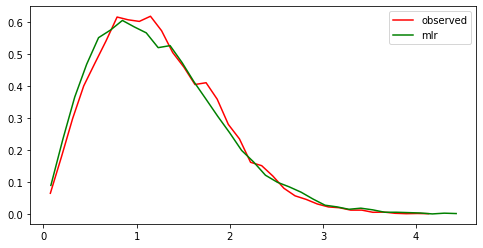

In [18]:
plt.figure(figsize=(16,8))
n1,x1,_=plt.hist(amp1_wh04_filt,bins=35,density=True,alpha=0.5,histtype='step',label='observed')

n2,x2,_=plt.hist(amp1_mlr,bins=35,density=True,alpha=0.5,histtype='step',label='mlr')

plt.clf()
plt.figure(figsize=(8,4))

plt.legend()
bin_centers1 = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers1,n1,'r',label='observed')
bin_centers2 = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers2,n2,'g',label='mlr')
# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')
plt.legend()

## SVR

In [19]:
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm1_1905_2015_svr_org_new.txt')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11 = df11.drop('Datetime',axis=1)
df11 = df11[['rmm1']]/df11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm2_1905_2015_svr_org_new.txt')
df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22 = df22.drop('Datetime',axis=1)
df22 = df22[['rmm2']]/df22['rmm2'].loc['1979-01-01':'2008-12-31'].std()

# df11.columns =['rmm1']
# df22.columns =['rmm2']



d1_svr = df11['rmm1'][(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_svr = df22['rmm2'][(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]

mjo_ind_svr = (d1_svr**2+d2_svr**2)**0.5

phase1_svr = theta1_cal( d1_svr, d2_svr )
amp1_svr = mjo_ind_svr.loc[str(st)+'-01-01':str(en)+'-12-31']
print(np.mean(amp1_svr),np.std(amp1_svr)*factor,np.std(amp1_svr.loc['1979-01-01':'2008-12-31'])*factor)

1.2319879833830338 1.0194484516664675 1.0163116171798456


(14.262962482087376,
 10.221467363433119,
 10.744507640857465,
 10.288882889367102)

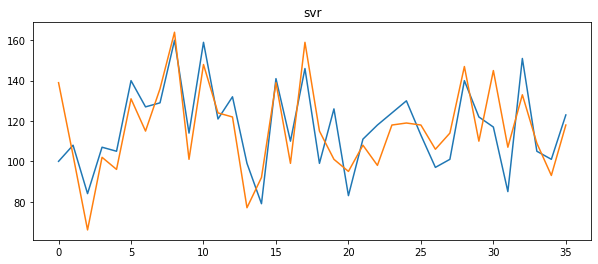

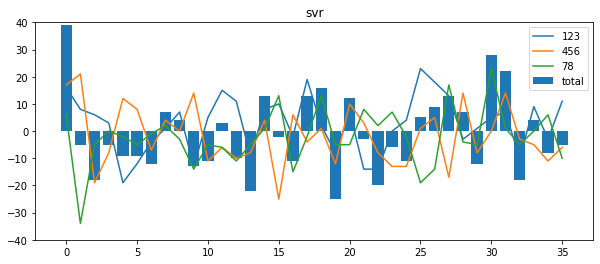

In [22]:
threshold = np.std(amp1_svr.loc['1979-01-01':'2008-12-31'])*factor
tt_svr = tot_phase(phase1_svr,amp1_svr,threshold,st,n)
t123_svr, t567_svr,t78_svr = phase_freq_cal(phase1_svr,amp1_svr,threshold,st,n)
plt.figure(figsize=(10,4))
plt.plot(tt_wh04)
plt.plot(tt_svr)
plt.title('svr')

plt.figure(figsize=(10,4))
plt.plot(t123_svr-t123_wh04,label='123')
plt.plot(t567_svr-t567_wh04,label='456')
plt.plot(t78_svr-t78_wh04,label='78')
plt.bar(np.arange(36),tt_svr-tt_wh04,label='total')
plt.ylim([-40,40])
plt.title('svr')
plt.legend()
np.std(tt_svr-tt_wh04),np.std(t123_svr-t123_wh04),np.std(t567_svr-t567_wh04),np.std(t78_svr-t78_wh04)

No handles with labels found to put in legend.


<Figure size 1152x576 with 0 Axes>

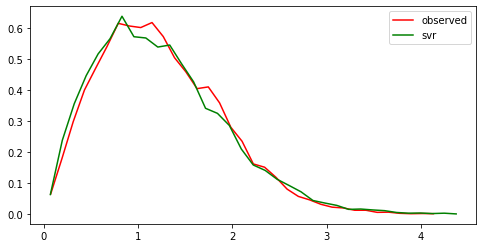

In [23]:
plt.figure(figsize=(16,8))
n1,x1,_=plt.hist(amp1_wh04_filt,bins=35,density=True,alpha=0.5,histtype='step',label='observed')

n2,x2,_=plt.hist(amp1_svr,bins=35,density=True,alpha=0.5,histtype='step',label='svr')

plt.clf()
plt.figure(figsize=(8,4))

plt.legend()
bin_centers1 = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers1,n1,'r',label='observed')
bin_centers2 = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers2,n2,'g',label='svr')
# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')
plt.legend()

(0.4187902187902188,
 0.18082368082368083,
 0.22831402831402833,
 0.22033462033462037,
 0.05537961261407206,
 0.31405062244224835,
 0.3024172687200043,
 0.3364715355015755,
 0.32211320809972344,
 0.1726213726164918,
 0.17675728297114499,
 0.16491304868766446)

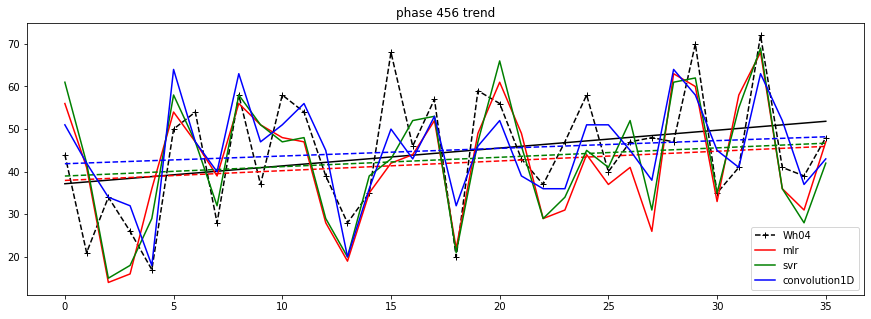

In [24]:
plt.figure (figsize=(15,5))
plt.plot(t567_wh04,'k+--',label = 'Wh04')
m_wh04,c_wh04,r_wh04,p_wh04,_ = stats.linregress(np.arange(1,len(t567_wh04)+1),t567_wh04)
plt.plot(m_wh04*np.arange(1,len(t567_wh04)+1)+c_wh04,'k')



# plt.plot(t567_ol,'r',label ='ol')
# m_ol,c_ol,r_ol,p_ol,_ = stats.linregress(np.arange(1,len(t567_ol)+1),t567_ol)
# plt.plot(m_ol*np.arange(1,len(t567_ol)+1)+c_ol,'--r')


plt.plot(t567_mlr,'r',label ='mlr')
m_mlr,c_mlr,r_mlr,p_mlr,_ = stats.linregress(np.arange(1,len(t567_mlr)+1),t567_mlr)
plt.plot(m_mlr*np.arange(1,len(t567_mlr)+1)+c_mlr,'--r')

plt.plot(t567_svr,'g',label ='svr')
m_svr,c_svr,r_svr,p_svr,_ = stats.linregress(np.arange(1,len(t567_svr)+1),t567_svr)
plt.plot(m_svr*np.arange(1,len(t567_svr)+1)+c_svr,'--g')

plt.plot(t567_conv,'b',label = 'convolution1D')
m_conv,c_conv,r_conv,p_conv,_ = stats.linregress(np.arange(1,len(t567_conv)+1),t567_conv)
plt.plot(m_conv*np.arange(1,len(t567_conv)+1)+c_conv,'--b')
plt.legend()
plt.title('phase 456 trend')


m_wh04,m_conv,m_mlr,m_svr,p_wh04,p_conv,p_mlr,p_svr,r_wh04,r_conv,r_mlr,r_svr


(0.4394680394680395,
 0.18601458601458598,
 0.22758472758472761,
 0.00011075639197416532,
 0.06379390343148635,
 0.08529783198476612,
 0.5997347728498456,
 0.31218202671776607,
 0.2908180808854)

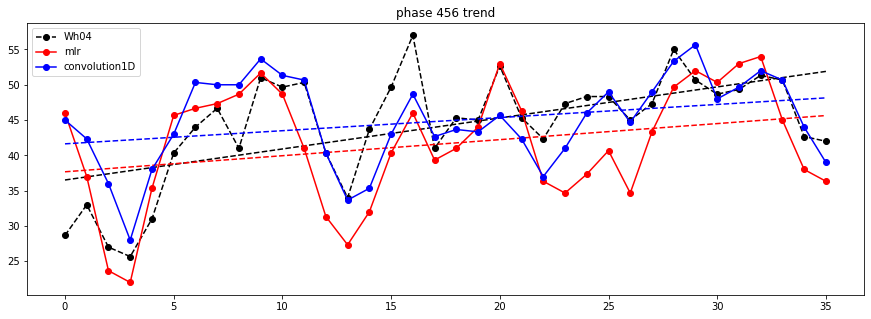

In [25]:
window_len = 3 
t567_conv_3yr= smooth(t567_conv,window_len,window='flat')[1:-1]
t567_mlr_3yr= smooth(t567_mlr,window_len,window='flat')[1:-1]
t567_wh04_3yr= smooth(t567_wh04,window_len,window='flat')[1:-1]

plt.figure (figsize=(15,5))
plt.plot(t567_wh04_3yr,'ko--',label = 'Wh04')
m_wh04,c_wh04,r_wh04,p_wh04,_ = stats.linregress(np.arange(1,len(t567_wh04)+1),t567_wh04_3yr)
plt.plot(m_wh04*np.arange(1,len(t567_wh04)+1)+c_wh04,'--k')


plt.plot(t567_mlr_3yr,'ro-',label ='mlr')
m_mlr,c_mlr,r_mlr,p_mlr,_ = stats.linregress(np.arange(1,len(t567_mlr)+1),t567_mlr_3yr)
plt.plot(m_mlr*np.arange(1,len(t567_mlr)+1)+c_mlr,'--r')



plt.plot(t567_conv_3yr,'bo-',label = 'convolution1D')
m_conv,c_conv,r_conv,p_conv,_ = stats.linregress(np.arange(1,len(t567_conv)+1),t567_conv_3yr)
plt.plot(m_conv*np.arange(1,len(t567_conv)+1)+c_conv,'--b')
plt.legend()
plt.title('phase 456 trend')


m_wh04,m_conv,m_mlr,p_wh04,p_conv,p_mlr,r_wh04,r_conv,r_mlr



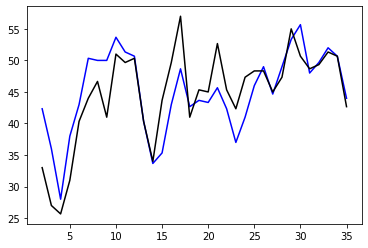

In [26]:
plt.plot(pd.DataFrame(t567_conv).rolling(3).mean(),'b')
plt.plot(pd.DataFrame(t567_wh04).rolling(3).mean(),'k')
# plt.plot(pd.DataFrame(t567_mlr).rolling(3).mean(),'r')


In [27]:
# plt.plot(smooth(t567_conv,window_len,window='flat')[1:-1])
# plt.plot(pd.DataFrame(t567_conv).rolling(window_len,center=True).mean())

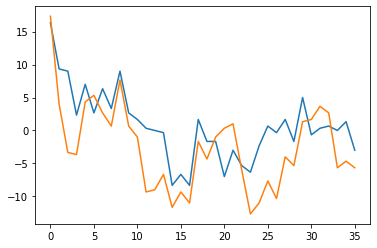

In [28]:
plt.plot(t567_conv_3yr-t567_wh04_3yr)

plt.plot(t567_mlr_3yr-t567_wh04_3yr)


(-0.2676962676962677,
 -0.2624195624195624,
 -0.138996138996139,
 0.25742162884515446,
 0.23855313831528907,
 0.5759179821038065,
 -0.19379422347624592,
 -0.20152402386791843,
 -0.0964110877440426)

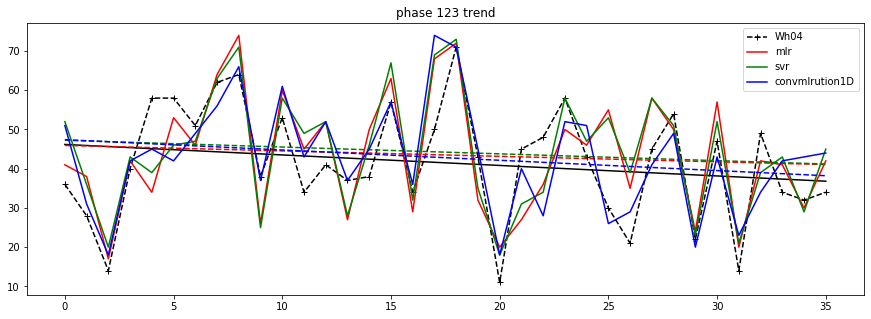

In [29]:
plt.figure (figsize=(15,5))
plt.plot(t123_wh04,'k+--',label = 'Wh04')
m_wh04,c_wh04,r_wh04,p_wh04,_ = stats.linregress(np.arange(1,len(t123_wh04)+1),t123_wh04)
plt.plot(m_wh04*np.arange(1,len(t123_wh04)+1)+c_wh04,'k')
plt.plot(t123_mlr,'r',label ='mlr')
m_mlr,c_mlr,r_mlr,p_mlr,_ = stats.linregress(np.arange(1,len(t123_mlr)+1),t123_mlr)
plt.plot(m_mlr*np.arange(1,len(t123_mlr)+1)+c_mlr,'--r')


plt.plot(t123_svr,'g',label ='svr')
m_svr,c_svr,r_svr,p_svr,_ = stats.linregress(np.arange(1,len(t123_svr)+1),t123_svr)
plt.plot(m_svr*np.arange(1,len(t123_svr)+1)+c_svr,'--g')

plt.plot(t123_conv,'b',label = 'convmlrution1D')
m_conv,c_conv,r_conv,p_conv,_ = stats.linregress(np.arange(1,len(t123_conv)+1),t123_conv)
plt.plot(m_conv*np.arange(1,len(t123_conv)+1)+c_conv,'--b')
plt.legend()
plt.title('phase 123 trend')
m_wh04,m_conv,m_mlr,p_wh04,p_conv,p_mlr,r_wh04,r_conv,r_mlr


(-0.2585156585156585,
 -0.23329043329043334,
 -0.1525954525954526,
 0.08004400567973827,
 0.10323240589593174,
 0.2844253285191205,
 -0.2956113563090715,
 -0.27599981205637897,
 -0.18335823878121618)

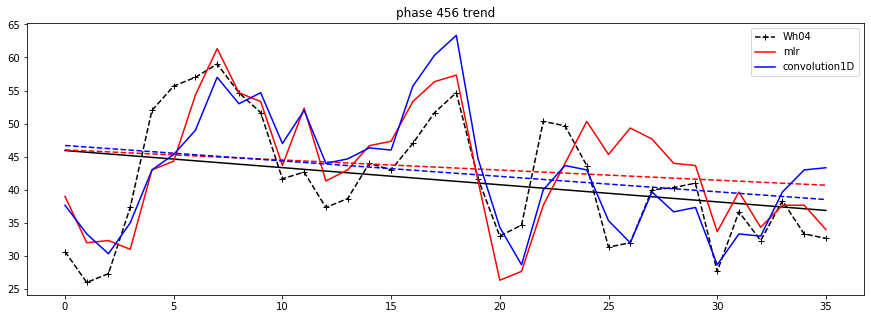

In [30]:
window_len = 3 
t123_conv_3yr= smooth(t123_conv,window_len,window='flat')[1:-1]
t123_mlr_3yr= smooth(t123_mlr,window_len,window='flat')[1:-1]
t123_wh04_3yr= smooth(t123_wh04,window_len,window='flat')[1:-1]

plt.figure (figsize=(15,5))
plt.plot(t123_wh04_3yr,'k+--',label = 'Wh04')
m_wh04,c_wh04,r_wh04,p_wh04,_ = stats.linregress(np.arange(1,len(t123_wh04)+1),t123_wh04_3yr)
plt.plot(m_wh04*np.arange(1,len(t123_wh04)+1)+c_wh04,'k')


plt.plot(t123_mlr_3yr,'r',label ='mlr')
m_mlr,c_mlr,r_mlr,p_mlr,_ = stats.linregress(np.arange(1,len(t123_mlr)+1),t123_mlr_3yr)
plt.plot(m_mlr*np.arange(1,len(t123_mlr)+1)+c_mlr,'--r')


plt.plot(t123_conv_3yr,'b',label = 'convolution1D')
m_conv,c_conv,r_conv,p_conv,_ = stats.linregress(np.arange(1,len(t123_conv)+1),t123_conv_3yr)
plt.plot(m_conv*np.arange(1,len(t123_conv)+1)+c_conv,'--b')
plt.legend()
plt.title('phase 456 trend')


m_wh04,m_conv,m_mlr,p_wh04,p_conv,p_mlr,r_wh04,r_conv,r_mlr

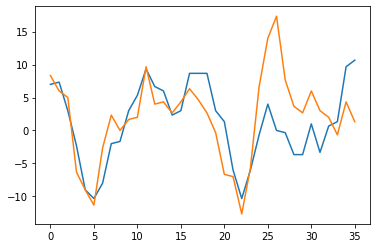

In [31]:
# plt.plot(smooth(t123_conv,window_len,window='flat')[1:-1])
# plt.plot(pd.DataFrame(t123_conv).rolling(window_len,center=True).mean())

plt.plot(t123_conv_3yr-t123_wh04_3yr)
plt.plot(t123_mlr_3yr-t123_wh04_3yr)


In [32]:
np.corrcoef(t567_svr,t567_wh04)[0,1],np.corrcoef(t123_svr,t123_wh04)[0,1]

(0.6924509894590501, 0.7520323821659192)

In [33]:
np.corrcoef(t567_mlr,t567_wh04)[0,1],np.corrcoef(t123_mlr,t123_wh04)[0,1]

(0.6492644920909294, 0.7524955491945546)

## 1905-2015

In [34]:
import pandas as pd
from scipy import stats
plt.rcParams['figure.figsize'] = (20,5)



st = 1905; en = 2015;
n= en-st

d1_conv_hist = df11_conv['rmm1'][(df11_conv.index >= datetime.datetime(st,1,1)) & (df11_conv.index  <= datetime.datetime(en,12,31))]
d2_conv_hist = df22_conv['rmm2'][(df22_conv.index >= datetime.datetime(st,1,1)) & (df22_conv.index  <= datetime.datetime(en,12,31))]

mjo_ind_conv_hist = (d1_conv_hist**2+d2_conv_hist**2)**0.5

phase1_conv_hist = theta1_cal( d1_conv_hist, d2_conv_hist )
amp1_conv_hist = mjo_ind_conv_hist *1
threshold_c = np.std(amp1_conv_hist.loc['1979-01-01':'2008-12-31'])*factor
t123_conv_hist, t567_conv_hist,_ = phase_freq_cal(phase1_conv_hist,amp1_conv_hist,threshold_c,st,n)


df2 = pd.read_csv('rmm_oliver_20CRv3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)



d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_ol = (d1_ol**2+d2_ol**2)**0.5


phase1_ol_hist = theta1_cal( d1_ol, d2_ol )
amp1_ol_hist = mjo_ind_ol*1
threshold_o = np.std(amp1_ol.loc['1979-01-01':'2008-12-31'])*factor

t123_ol_hist, t567_ol_hist,_ = phase_freq_cal(phase1_ol_hist,amp1_ol_hist,threshold_o,st,n)
### mlr ###
d1_mlr = df11['rmm1'][(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_mlr = df22['rmm2'][(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]

mjo_ind_mlr = (d1_mlr**2+d2_mlr**2)**0.5

phase1_mlr_hist = theta1_cal( d1_mlr, d2_mlr )
amp1_mlr_hist = mjo_ind_mlr.loc[str(st)+'-01-01':str(en)+'-12-31']
threshold_mlr = np.std(amp1_ol.loc['1979-01-01':'2008-12-31'])*factor
t123_mlr_hist, t567_mlr_hist,_ = phase_freq_cal(phase1_mlr_hist,amp1_mlr_hist,threshold_mlr,st,n)



##svr
### svr ###
d1_svr = df11['rmm1'][(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_svr = df22['rmm2'][(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]

mjo_ind_svr = (d1_svr**2+d2_svr**2)**0.5

phase1_svr_hist = theta1_cal( d1_svr, d2_svr )
amp1_svr_hist = mjo_ind_svr.loc[str(st)+'-01-01':str(en)+'-12-31']
threshold_svr = np.std(amp1_ol.loc['1979-01-01':'2008-12-31'])*factor
t123_svr_hist, t567_svr_hist,_ = phase_freq_cal(phase1_svr_hist,amp1_svr_hist,threshold_svr,st,n)

In [35]:
pdo = pd.read_csv('pdo_index.txt',sep ='   ',header = None)
pdo.columns = ['year','pdo']
pdo.index= pdo.year
pdo =pdo.drop('year',axis=1)
pdot = pdo.loc['1906':'2015']

/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


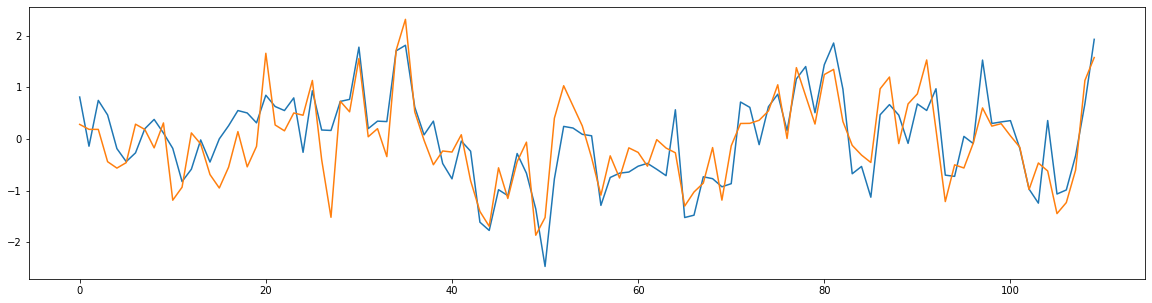

In [36]:
pdo=pd.read_fwf('/home/cccr/roxy/panini/JGRJD_PHD_PART_I/DATA/indices/pdo/pdo_index.txt')
pdo_sel=pdo.set_index('YEAR').loc[1905:2015]
pdo_winter=pdo_sel[['JAN','FEB','MAR','APR','NOV','DEC']].values.ravel()
k=5
pdo_winter_mean=np.zeros((110,))
for i in np.arange(110):
    pdo_winter_mean[i]=np.mean(pdo_winter[k:k+6])
    k=k+6
    
plt.plot(pdo_winter_mean)
plt.plot(pdot.values)

NameError: name 're_lsq' is not defined

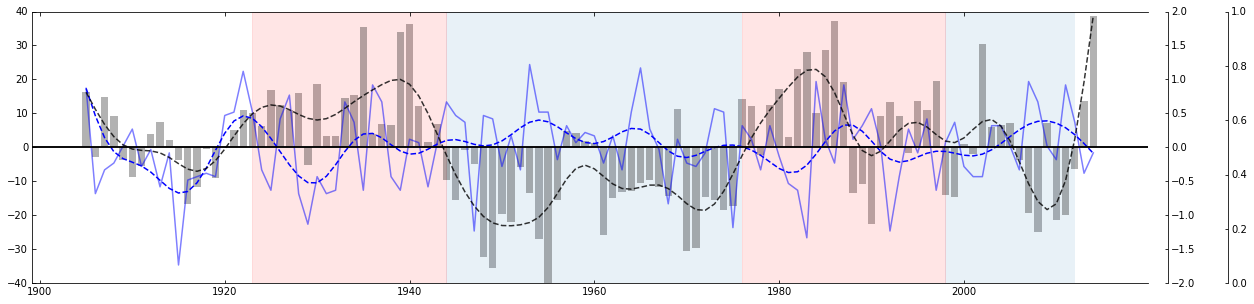

In [37]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)

# plt.plot(np.arange(1905,2015,1),t567_ol)

t567_conv_detrend = signal.detrend(t567_conv_hist)
plt.plot(np.arange(1905,2015,1),t567_conv_hist-np.mean(t567_conv_hist),'b',alpha=0.5)
# t567_ol_detrend = signal.detrend(t567_ol_hist)
# plt.plot(np.arange(1905,2015,1),t567_ol_hist-np.mean(t567_ol_hist),'r',alpha=0.3)


plt.plot(np.arange(1905,2015,1),lowpass_scipy_butter(t567_conv_hist-np.mean(t567_conv_hist),wn,10),'--b')
# plt.plot(np.arange(1905,2015,1),lowpass_scipy_butter(t567_ol_detrend,wn,10),'r')
mean_1 = 0

plt.axhline(mean_1,color ='k')
plt.ylim([mean_1-40,mean_1+40])



ax2 = host.twinx()
ax3 = host.twinx()
offset = 80
new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
ax3.axis["right"] = new_fixed_axis(loc="right",
                                    axes=ax3,
                                    offset=(offset, 0))

ax2.axis["right"].toggle(all=True)

offset = 20
new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
ax2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=ax2,
                                    offset=(offset, 0))

ax3.axis["right"].toggle(all=True)

# ax2.bar(np.arange(1905,2015,1),pdot.values[:,0],color='k',alpha=0.3)
# ax2.plot(np.arange(1905,2015,1),lowpass_scipy_butter(pdot.values[:,0],wn,10),'--k',alpha=0.8)

ax2.bar(np.arange(1905,2015,1),pdo_winter_mean,color='k',alpha=0.3)
ax2.plot(np.arange(1905,2015,1),lowpass_scipy_butter(pdo_winter_mean,wn,10),'--k',alpha=0.8)


mean_2 =0
ax2.axhline(mean_2,color ='k')
ax2.set_ylim([mean_2-2,mean_2+2])

ax2.axvspan(1944,1976,alpha = 0.1)
ax2.axvspan(1923,1944,color = 'r',alpha = 0.1)
ax2.axvspan(1976,1998,color = 'r',alpha = 0.1)
ax2.axvspan(1998,2012,alpha = 0.1)


# ax3.plot(np.arange(1905,2015-35,1)+18,re_mlr,'orange')
ax3.plot(np.arange(1905,2015-35,1)+18,re_lsq,'r')
ax3.scatter(np.arange(1905,2015-35,1)+18,pp,color = 'r')

ax3.set_ylim([-0.6,0.6])

host.axis["left"].label.set_color('k')
ax2.axis["right"].label.set_color('blue')
ax3.axis["right"].label.set_color('r')

In [ ]:
start = 20
# print(np.corrcoef(pdot.values[start:,0],t567_conv_hist[start:]))
# print(np.corrcoef(pdot.values[start:,0],t567_ol_hist[start:]))
print(np.corrcoef(pdo_winter_mean[start:],t567_conv_hist[start:]))
print(np.corrcoef(pdo_winter_mean[start:],t567_mlr_hist[start:]))

print(np.corrcoef(smooth(pdo_winter_mean[start:],window_len=7,window='flat')[3:-3],smooth(t567_conv_hist[start:],window_len=7,window='flat')[3:-3]))
print(np.corrcoef(smooth(pdo_winter_mean[start:],window_len=7,window='flat')[3:-3],smooth(t567_mlr_hist[start:],window_len=7,window='flat')[3:-3]))

# print(np.corrcoef(lowpass_scipy_butter(pdot.values[start:,0],wn,10),lowpass_scipy_butter(t567_conv_hist[start:],wn,10)))
# print(np.corrcoef(lowpass_scipy_butter(pdot.values[start:,0],wn,10),lowpass_scipy_butter(t567_ol_hist[start:],wn,10)))

print(np.corrcoef(lowpass_scipy_butter(pdo_winter_mean[start:],wn,10),lowpass_scipy_butter(t567_conv_hist[start:],wn,10)))
print(np.corrcoef(lowpass_scipy_butter(pdo_winter_mean[start:],wn,10),lowpass_scipy_butter(t567_mlr_hist[start:],wn,10)))

plt.figure(figsize=(8,8))
plt.scatter(smooth(pdo_winter_mean[start:],window_len=7,window='flat')[3:-3],smooth(t567_conv_hist[start:],window_len=7,window='flat')[3:-3])
plt.ylim([10,70])
plt.xlim([-2,2])
plt.axvline(0,color='k')
plt.axhline(35,color='k')

plt.xlabel('PDO')
plt.ylabel('duration456')
# plt.title('correlation=0.52')

In [ ]:
import pandas as pd
from scipy import stats
plt.figure(figsize = (16,8))
t567_10yr = smooth(t567_conv_hist,window_len=11,window='flat')[5:-5]
plt.plot(t567_10yr,'orange')
plt.plot(t567_conv_hist,'b')
res = stats.linregress(np.arange(1,len(t567_10yr[0:])+1), t567_10yr[0:])
plt.plot(res[0]*np.arange(1,len(t567_10yr)+1)+res[1])
res

In [ ]:
k= 35 
re=np.zeros((len(t567_conv_hist)-k))
re_lsq=np.zeros((len(t567_conv_hist)-k))
pp = np.zeros((len(t567_conv_hist)-k))
pp.fill(np.nan)
re_mlr=np.zeros((len(t567_conv_hist)-k))
re_lsq_mlr=np.zeros((len(t567_conv_hist)-k))
pp_mlr = np.zeros((len(t567_conv_hist)-k))
pp_mlr.fill(np.nan)
yy=np.zeros((len(t567_conv_hist)-k))

year = np.arange(1905,2015)

for i in np.arange(len(t567_conv_hist)-k):
    x= np.arange(1,k+1)
    y= t567_conv_hist[i:i+k]
    y1= t567_ol_hist[i:i+k]
    
    
    res = stats.theilslopes(y, x)
    lsq_res = stats.linregress(x, y)
    re[i]=res[0]
    re_lsq[i]=lsq_res[0]
    if lsq_res[3]<0.1:
        pp[i] = lsq_res[0]
    
    
    res = stats.theilslopes(y1, x)
    lsq_res = stats.linregress(x, y1)
    re_mlr[i]=res[0]
    re_lsq_mlr[i]=lsq_res[0]
    yy[i] = year[i]
    if lsq_res[3]<0.1:
        pp_mlr[i] = lsq_res[0]

In [ ]:
plt.plot(yy+18,re_lsq_mlr,'b')
plt.scatter(yy+18,pp_mlr)

plt.plot(yy+18,re_lsq,'orange')
plt.scatter(yy+18,pp)
plt.axhline(0)

In [38]:
t567_conv_hist_2d = t567_conv_hist*1
t123_conv_hist_2d = t123_conv_hist*1


In [39]:
%store t567_conv_hist_2d
%store t123_conv_hist_2d

# %store phase1_conv_hist
# %store phase1_ol_hist
# %store amp1_conv_hist
# %store amp1_ol_hist
# %store amp1_wh04_filt 
# %store phase1_wh04_filt

%store t123_svr_hist
%store t567_svr_hist

Stored 't567_conv_hist_2d' (ndarray)
Stored 't123_conv_hist_2d' (ndarray)
Stored 't123_svr_hist' (ndarray)
Stored 't567_svr_hist' (ndarray)


In [40]:
t567_mlr_hist

array([41., 18.,  9., 27., 39., 44.,  3., 26.,  3., 36.,  1., 24., 37.,
       10., 16., 40., 39., 58., 23., 25., 10., 47., 53., 28., 14.,  4.,
       22., 22., 59., 34., 20., 46., 39., 35., 17., 47., 38., 34., 30.,
       59., 54., 16., 17., 41., 51., 40., 35., 20., 43., 60., 43., 35.,
       37., 24., 44., 36., 39., 52., 32., 44., 29., 48., 46., 26., 31.,
       35., 32., 28., 61., 45., 32., 48., 32., 31., 51., 39., 12., 14.,
       22., 55., 45., 30., 55., 44., 47., 39., 26., 17., 35., 38., 42.,
       52., 20., 45., 56., 45., 27., 25., 41., 37., 43., 26., 59., 57.,
       35., 54., 68., 30., 26., 38.])